In [30]:
import networkx as nx
import dill as pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.optimize as opt
import copy
from mpl_toolkits.basemap import Basemap
import collections
import pandas as pd

In [31]:
# Read pickled graphs graph_objects/G_multi_directed.pickle, graph_objects/G_multi_undirected.pickle, graph_objects/G_simple_directed.pickle, graph_objects/G_simple_undirected.pickle
with open('graph_objects/G_multi_directed_iggielgn.pickle', 'rb') as f:
    G_multi_directed = pickle.load(f)

with open('graph_objects/G_multi_undirected_iggielgn.pickle', 'rb') as f:
    G_multi_undirected = pickle.load(f)

with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)

with open('graph_objects/G_simple_undirected_iggielgn.pickle', 'rb') as f:
    G_simple_undirected = pickle.load(f)

In [32]:
# Output a value count for the country_code attribute of the nodes in the graph
print('G_multi_directed')
print(pd.Series(nx.get_node_attributes(G_multi_directed, 'country_code')).value_counts())

G_multi_directed
DE    631
FR    622
RU    387
IT    373
ES    210
PL    198
UA    198
TR    180
GB    178
RO    162
DZ    160
NL    102
HU     99
BY     87
BG     75
BE     70
IE     52
AT     51
RS     42
CZ     41
FI     40
GE     39
HR     36
LT     35
GR     33
PT     29
CH     28
EG     25
EE     24
SI     23
DK     21
LV     20
KZ     20
MD     19
TN     19
SE     18
SK     18
AM      9
SY      9
IL      9
AZ      9
IQ      7
NO      7
LU      5
LY      4
MK      4
IR      3
JO      2
MA      2
AL      2
IM      2
BA      2
EL      2
MT      1
Name: count, dtype: int64


In [33]:
# Create a dictionary. The keys are the country_codes and the values are 1) the number of nodes in the country 2) the number of to_edges in the country 3) the number of from_edges in the country 4) the number of total edges in the country

country_dict = {}
for node in G_multi_directed.nodes:
    country_code = G_multi_directed.nodes[node]['country_code']
    if country_code in country_dict:
        country_dict[country_code][0] += 1
    else:
        country_dict[country_code] = [1, 0, 0]

for edge in G_multi_directed.edges(data=True):
    from_country_code = edge[2]['from_country_code']
    to_country_code = edge[2]['to_country_code']
    if from_country_code in country_dict:
        country_dict[from_country_code][1] += 1
    else:
        country_dict[from_country_code] = [0, 1, 0]
    if to_country_code in country_dict:
        country_dict[to_country_code][2] += 1

In [34]:
countries_df = pd.DataFrame.from_dict(country_dict, orient='index', columns=['number_of_nodes', 'number_of_to_edges', 'number_of_from_edges'])
countries_df.head()
countries_list = countries_df.index.tolist()

/var/folders/vr/0qryf_g13n11tpz1djg9ycb80000gn/T/ipykernel_10270/3318741531.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if countries_df['number_of_nodes'][i] > 300:
/var/folders/vr/0qryf_g13n11tpz1djg9ycb80000gn/T/ipykernel_10270/3318741531.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (countries_df['number_of_nodes'][i], countries_df['number_of_to_edges'][i]))


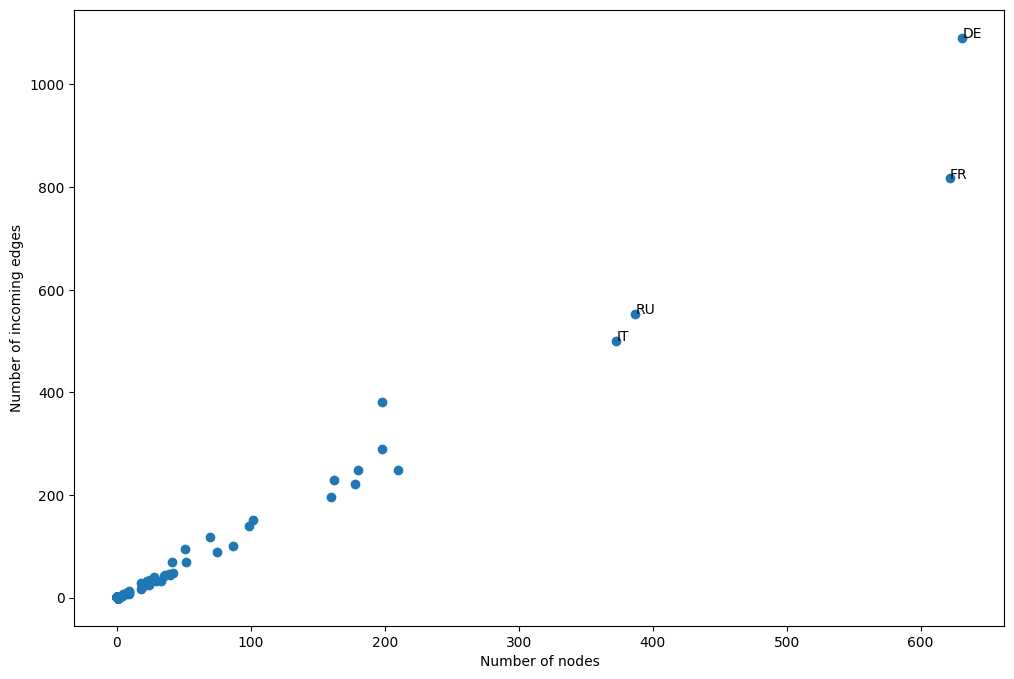

In [35]:
# Using the number_nodes as the x-axis and the number_of_to_edges as the y-axis, plot the number of to_edges vs the number of nodes
plt.figure(figsize=(12, 8))
plt.scatter(countries_df['number_of_nodes'], countries_df['number_of_to_edges'])
plt.xlabel('Number of nodes')
plt.ylabel('Number of incoming edges')
for i, txt in enumerate(countries_df.index):
    if countries_df['number_of_nodes'][i] > 300:
        plt.annotate(txt, (countries_df['number_of_nodes'][i], countries_df['number_of_to_edges'][i]))

plt.savefig('latex_figures/number_of_nodes_vs_number_of_to_edges.png')
plt.show()

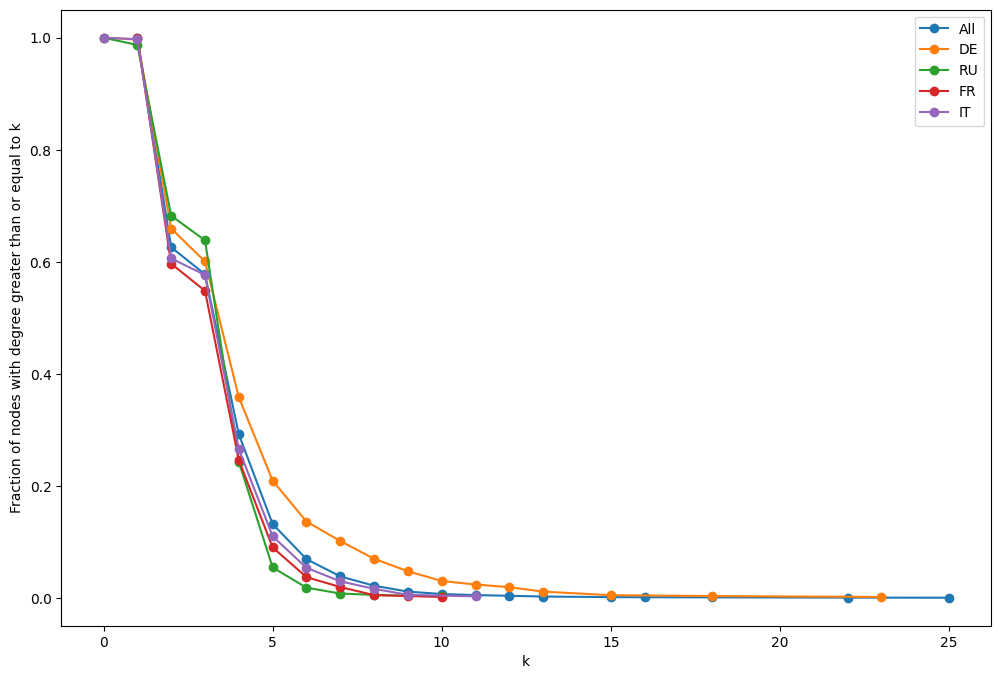

In [36]:
# Do the same as above, but do five different series, one for the entire graph, one for nodes where country_code is DE, RU, FR, and IT
plt.figure(figsize=(12, 8))
# Keep in min I want to plot the fraction of nodes with degree greater than or equal to k vs k
# One would expect the curve to begin at 1 and decrease to 0
degree_sequence = sorted([d for n, d in G_multi_directed.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cumulative_cnt = np.cumsum(cnt)
cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
plt.plot(deg, cumulative_cnt, 'o-', label='All')

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    degree_sequence = sorted([d for n, d in sub_graph.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    cumulative_cnt = np.cumsum(cnt)
    cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
    plt.plot(deg, cumulative_cnt, 'o-', label=country_code)

plt.xlabel('k')
plt.ylabel('Fraction of nodes with degree greater than or equal to k')
plt.legend()

plt.savefig('latex_figures/degree_distribution_selected.png')
plt.show()

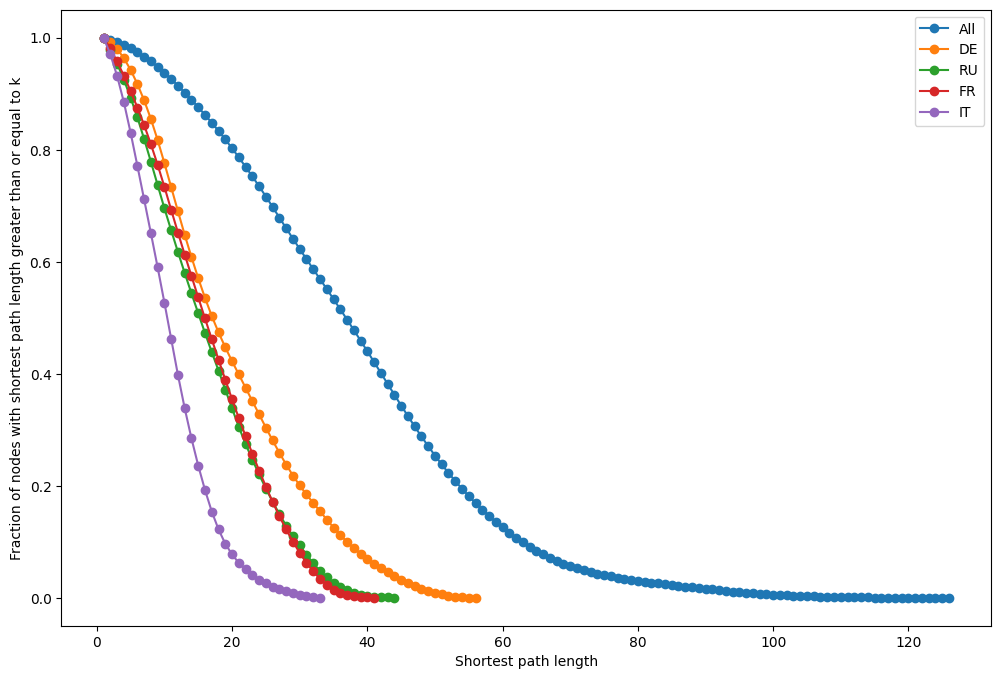

In [37]:
# Do the same as above, only do the shortest path length distribution
plt.figure(figsize=(12, 8))
shortest_path_lengths = nx.shortest_path_length(G_multi_directed)
shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
spl, cnt = zip(*shortest_path_lengths_count.items())
cumulative_cnt = np.cumsum(cnt)
cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
plt.plot(spl, cumulative_cnt, 'o-', label='All')

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    shortest_path_lengths = nx.shortest_path_length(sub_graph)
    shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
    shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
    shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
    shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
    spl, cnt = zip(*shortest_path_lengths_count.items())
    cumulative_cnt = np.cumsum(cnt)
    cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
    plt.plot(spl, cumulative_cnt, 'o-', label=country_code)
    
plt.xlabel('Shortest path length')
plt.ylabel('Fraction of nodes with shortest path length greater than or equal to k')
plt.legend()

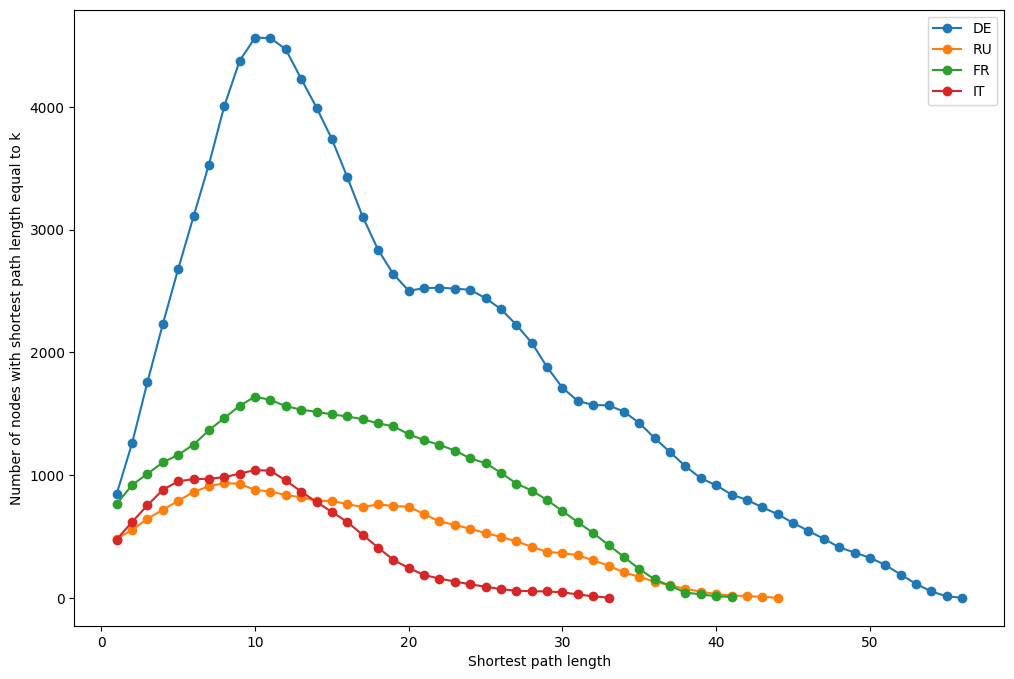

In [38]:
# Plot the normal shortest path length distribution (i.e., not cumulative)
plt.figure(figsize=(12, 8))

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    shortest_path_lengths = nx.shortest_path_length(sub_graph)
    shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
    shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
    shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
    shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
    spl, cnt = zip(*shortest_path_lengths_count.items())
    plt.plot(spl, cnt, 'o-', label=country_code)

plt.xlabel('Shortest path length')
plt.ylabel('Number of nodes with shortest path length equal to k')
plt.legend()

plt.savefig('latex_figures/shortest_path_length_distribution_selected.png')
plt.show()

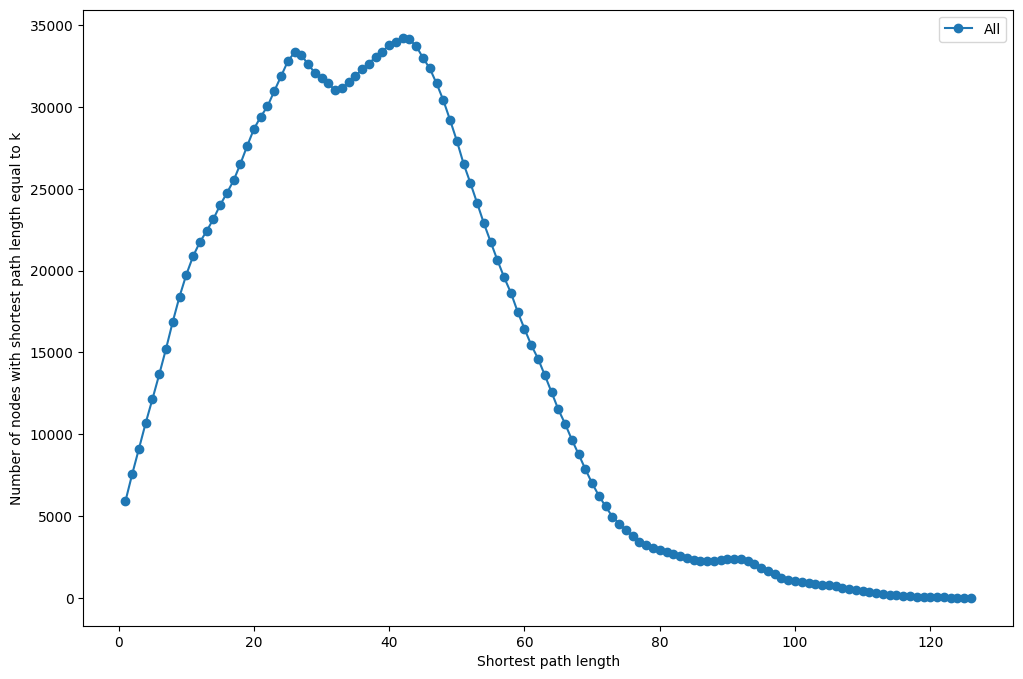

In [39]:
# Do the same for the entire graph
plt.figure(figsize=(12, 8))
shortest_path_lengths = nx.shortest_path_length(G_multi_directed)
shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
spl, cnt = zip(*shortest_path_lengths_count.items())
plt.plot(spl, cnt, 'o-', label='All')

plt.xlabel('Shortest path length')
plt.ylabel('Number of nodes with shortest path length equal to k')
plt.legend()

plt.savefig('latex_figures/shortest_path_length_distribution_all.png')
plt.show()